#### Chapter 10: Counting and Classification

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import collections

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy.stats as stats

There are two experimental conditions:
1. _partner_ condition - chimp standing at other end
2. _control_ condition - nobody standing at other end

Two counterbalancing treatments alternate which side is social:
* Left is prosocial option
* Right is prosocial option

**The motivating question is whether a focal chimp chooses the prosocial option more often when another animal is present.**

In terms of linear model, we want to estimate the interaction between condition (presence or absence of another animal) and option (which side is prosocial). 



In [2]:
data = pd.read_csv('./rethinking/data/chimpanzees.csv', sep=';')

In [3]:
data.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


* `pulled_left` - outcome to predict: 0 or 1 indicator if the focal animal pulled the left-hand lever. 
* `prosoc_left` - predictor variable: 0 or 1 indicator that the left-hand level was (1) attached or (0) not attached to the prosocial option.
* `condition` - predictor variable: 0 or 1 indicator that there (1) was an animal on the other side, and (0) if there wasn't

$$L_i \sim Binomial(1, p_i)$$
$$logit(p_i) = \alpha + (\beta_P + \beta_{PC}C_i)P_i$$
$$\alpha \sim Normal(0, 10)$$
$$\beta_P \sim Normal(0, 10)$$
$$\beta_{RC} \sim Normal(0, 10)$$

* $L_i$ indicates `pulled_left`
* $P$ indicates `prosoc_left`
* $C$ indicates `condition`

In [4]:
data[['pulled_left', 'prosoc_left', 'condition']].head()

,pulled_left,prosoc_left,condition
0,0,0,0
1,1,0,0
2,0,1,0
3,0,0,0
4,1,1,0


Two other models to compare with:

$$L_i \sim Binomial(1, p_i)$$
$$logit(p_i) = \alpha$$
$$\alpha \sim Normal(0, 10)$$

--- 

$$L_i \sim Binomial(1, p_i)$$
$$logit(p_i) = \alpha + \beta_P P_i$$
$$\alpha \sim Normal(0, 10)$$
$$\beta_P \sim Normal(0, 10)$$

In [5]:
with pm.Model() as m101:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    p_i = pm.Deterministic('p_i', np.exp(alpha) / (1 + np.exp(alpha)))
    L_i = pm.Binomial('L_i', 1, p_i, observed=data['pulled_left'])
    
    m101_map = pm.find_MAP(model=m101)
    m101_traces = pm.sample(1000)

100%|██████████| 1000/1000 [00:00<00:00, 2438.38it/s]


In [6]:
m101_map

{'alpha': array(0.32014145398132277)}

Now to interpret the estimate for $\alpha$, remember that the parameters in the logistic regression are on the scale of log-odds. To get them back onto the probability scale, we have to use the inverse link function. In this case, the inverse link is logistic.

In this case:
$$p_i = \frac{e^{\alpha}}{1 + e^{\alpha}}$$

In [7]:
m101_alpha = m101_map['alpha']

np.exp(m101_alpha) / (1 + np.exp(m101_alpha))

0.57935872518109255

So the above summary implies that there is about $\sim$ 0.58 probability of left lever being pulled. 

In [8]:
with pm.Model() as m102:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_p = pm.Normal('beta_p', mu=0, sd=10)
    
    params = alpha + beta_p * data['prosoc_left']
    
    p_i = pm.Deterministic('p_i', np.exp(params) / (1 + np.exp(params)))
    L_i = pm.Binomial('L_i', 1, p_i, observed=data['pulled_left'])
    
    m102_map = pm.find_MAP()
    m102_traces = pm.sample(1000)

    
with pm.Model() as m103:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_p = pm.Normal('beta_p', mu=0, sd=10)
    beta_pc = pm.Normal('beta_pc', mu=0, sd=10)
    
    params = alpha + (beta_p + beta_pc * data['condition']) * data['prosoc_left']
    
    p_i = pm.Deterministic('p_i', np.exp(params) / (1 + np.exp(params)))
    L_i = pm.Binomial('L_i', 1, p_i, observed=data['pulled_left'])
    
    m103_map = pm.find_MAP()
    m103_traces = pm.sample(1000)

100%|██████████| 1000/1000 [00:01<00:00, 569.93it/s]


In [9]:
class ComparableModel(object): 
    
    def __init__(self, name, model, traces):
        self.name = name
        self.model = model
        self.traces = traces
        
        self.waic, self.waic_se, self.n_eff_params = pm.waic(self.traces, self.model, n_eff=True)
        
    
class ModelComparator(object):
    
    
    def __init__(self, models):
        self.models = sorted(models, key=lambda x: x.waic, reverse=False)
        
    def to_df(self):
        
        self.comparison_df = pd.DataFrame(columns=['Model Name', 'pWAIC', 'WAIC', 'SE'])
        
        for model in self.models:
            self.comparison_df = self.comparison_df.append({
                    'Model Name' : model.name, 'pWAIC' : model.n_eff_params,
                    'WAIC' : model.waic, 'SE' : model.waic_se  }, ignore_index=True)
        
        # compute dWAIC
        self.comparison_df['dWAIC'] = self.comparison_df['WAIC'] - self.comparison_df['WAIC'].min()
        
        # helper for weight
        self.comparison_df['dWAIC_exp'] = np.exp( -0.5 * self.comparison_df['dWAIC'])
        
        # compute weight
        self.comparison_df['weight'] = self.comparison_df['dWAIC_exp'] / np.sum(self.comparison_df['dWAIC_exp'].sum())
                
        return self.comparison_df[['Model Name', 'WAIC', 'pWAIC', 'dWAIC', 'weight', 'SE']].round(2)
    
    
    def to_plot(self):
        
        # they're plotted in reverse order, so sort by WAIC
        comparison_df = self.to_df()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 1.5))

        ax.scatter(comparison_df['WAIC'], comparison_df.index, facecolors='none', edgecolors='k', s=60)
        ax.scatter(comparison_df['WAIC'] - comparison_df['pWAIC'] * 2, comparison_df.index, facecolors='k', edgecolors='k', s=20)

        ax.hlines(comparison_df.index, comparison_df['WAIC'] - comparison_df['SE'], comparison_df['WAIC'] + comparison_df['SE'] )

        ax.set_title('WAIC')
        ax.set_xlabel('deviance')

        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(comparison_df['Model Name'])

        ax.grid();
        
        return (fig, ax);
        

In [10]:
model_comparator = ModelComparator([
        ComparableModel('m101', m101, m101_traces),
        ComparableModel('m102', m102, m102_traces),
        ComparableModel('m103', m103, m103_traces)])

In [11]:
model_comparator.to_df()

,Model Name,WAIC,pWAIC,dWAIC,weight,SE
0,m102,680.85,2.18,0.00,0.68,9.26
1,m103,682.49,3.07,1.64,0.30,9.59
2,m101,688.16,1.11,7.31,0.02,7.27


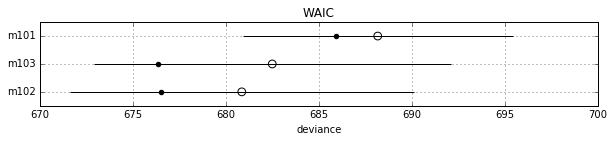

In [12]:
model_comparator.to_plot();

In [13]:
### I hate the chimp example

#### 10.1.3 Aggregate binomial: Graduate school admission

In [14]:
data = pd.read_csv('./rethinking/data/UCBadmit.csv', sep=';')

In [15]:
data.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [16]:
data['is_male'] = (data['applicant.gender'] == 'male').astype(int)

In [17]:
data['dept_id'] = (data.dept.rank(method='dense') - 1).astype(int)

In [18]:
data['applications'] = data['applications'].astype(np.int32)

Our job is to evaluate whether these data contain evidence of gender bias in admissions. We will model the admission decisions, focusing on applicant gender as a predictor variable. So we want to fit at least two models:

1. A binomial regression that models `admit` as a function of each applicant's gender. This will estimate the association between gender and the probability of admission.
2. A binomial regression that models `admit` as a constant, ignoring gender. This will allow us to get a sense of any overfitting committed by the first model.
---
This is what the first model looks like:

$$n_{admit, i} \sim Binomial(n_i, p_i)$$
$$logit(p_i) = \alpha + \beta m_i$$
$$ \alpha \sim Normal(0, 10)$$
$$ \beta_m \sim Normal(0, 10)$$

The variable $n_i$ indicates `applications[i]`, the number of applications on row `i` The predictor $m_i$ is a dummy that indicates "male".

In [19]:
with pm.Model() as m106:
    
    alpha = pm.Normal('alpha', 0, 10)
    beta_m = pm.Normal('beta_m', 0, 10)
    
    lin = alpha + beta_m * data['is_male']
    p = np.exp(lin) / (1 + np.exp(lin))
    
    admit = pm.Binomial('admit', n=data['applications'].values, p=p, observed=data['admit'])
        
    m106_map = pm.find_MAP()
    m106_traces = pm.sample(10000, start=m106_map)
    
    
with pm.Model() as m107:
    
    alpha = pm.Normal('alpha', 0, 10)
    
    lin = alpha
    p = np.exp(lin) / (1 + np.exp(lin))
    
    admit = pm.Binomial('admit', n=data['applications'].values, p=p, observed=data['admit'])
        
    m107_map = pm.find_MAP()
    m107_traces = pm.sample(10000, start=m107_map)

100%|██████████| 10000/10000 [00:02<00:00, 3974.00it/s]


In [20]:
model_comparator = ModelComparator([
        ComparableModel('m106', m106, m106_traces),
        ComparableModel('m107', m107, m107_traces)])

/Users/horatiu/anaconda/lib/python3.5/site-packages/pymc3/stats.py:178: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/horatiu/anaconda/lib/python3.5/site-packages/pymc3/stats.py:178: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [21]:
model_comparator.to_df()

,Model Name,WAIC,pWAIC,dWAIC,weight,SE
0,m106,994.67,116.17,0.0,1.0,315.36
1,m107,1034.77,80.11,40.1,0.0,309.39


In [22]:
m106_traces_df = pm.trace_to_dataframe(m106_traces)
m107_traces_df = pm.trace_to_dataframe(m107_traces)

In [23]:
m106_traces_df.head()

,alpha,beta_m
0,-0.879437,0.694930
1,-0.879437,0.694930
2,-0.787371,0.586264
3,-0.953573,0.762096
4,-0.988030,0.720946


In [24]:
p_admit_male = m106_traces_df.apply(lambda row: row['alpha'] + row['beta_m'], axis=1)
p_admit_female = m106_traces_df.apply(lambda row: row['alpha'], axis=1)

p_admit_male = p_admit_male.apply(lambda x: np.exp(x) / (1 + np.exp(x)))
p_admit_female = p_admit_female.apply(lambda x: np.exp(x) / (1 + np.exp(x)))

diff_admit = p_admit_male - p_admit_female

#
# The difference in the probability of admission is
#

diff_admit.quantile([0.025, 0.5, 0.975])

0.025    0.112786
0.500    0.141444
0.975    0.170436
dtype: float64

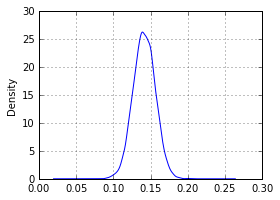

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

# diff_admit.plot(ax=ax, kind='kde')
diff_admit.plot(ax=ax, kind='kde')
ax.grid();

In [26]:
post = m106_traces_df.apply(lambda row: row['alpha'] + row['beta_m'] * data['is_male'], axis=1)
post = post.apply(lambda x: np.exp(x) / (1 + np.exp(x)))

In [27]:
quantiles = post.quantile([0.05, 0.975])

In [28]:
quantiles

,1,2,3,4,5,6,7,8,9,10,11,12
0.050,0.429676,0.285294,0.429676,0.285294,0.429676,0.285294,0.429676,0.285294,0.429676,0.285294,0.429676,0.285294
0.975,0.464330,0.325570,0.464330,0.325570,0.464330,0.325570,0.464330,0.325570,0.464330,0.325570,0.464330,0.325570


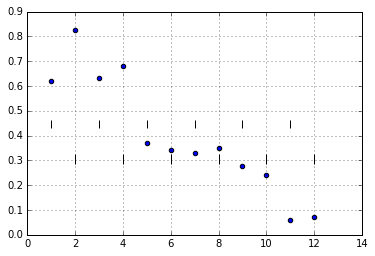

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

real_acceptance = data['admit'] / data['applications']

ax.scatter(real_acceptance.index, real_acceptance.values)

ax.vlines(real_acceptance.index, ymin=quantiles.iloc[0, :], ymax=quantiles.iloc[1, :])

ax.grid();

In [30]:
with pm.Model() as m108:
    
    alphas = pm.Normal('alphas', 0, 10, shape=6)
    beta_m = pm.Normal('beta_m', 0, 10)
    
    lin = alphas[data['dept_id']] + beta_m * data['is_male']
    p = np.exp(lin) / (1 + np.exp(lin))
    
    admit = pm.Binomial('admit', n=data['applications'].values, p=p, observed=data['admit'])
        
    m108_map = pm.find_MAP()
    m108_traces = pm.sample(1000, start=m108_map)

100%|██████████| 1000/1000 [00:01<00:00, 796.81it/s]


In [31]:
pm.summary(m108_traces)


alphas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.687            0.098            0.004            [0.496, 0.873]
  0.649            0.112            0.004            [0.437, 0.881]
  -0.580           0.073            0.002            [-0.726, -0.445]
  -0.608           0.088            0.003            [-0.777, -0.437]
  -1.060           0.103            0.003            [-1.252, -0.845]
  -2.624           0.152            0.007            [-2.916, -2.351]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.506          0.620          0.685          0.753          0.888
  0.433          0.580          0.646          0.721          0.879
  -0.721         -0.633         -0.576         -0.530         -0.428
  -0.777         -0.667         -0.606         -0.552         -0.437

In [32]:
m108_traces_df = pm.trace_to_dataframe(m108_traces)

In [33]:
m108_quantiles = m108_traces_df.quantile([0.025, 0.5, 0.975])

In [34]:
m108_quantiles.head()

,alphas__0,alphas__1,alphas__2,alphas__3,alphas__4,alphas__5,beta_m
0.025,0.505806,0.433363,-0.721414,-0.777186,-1.261313,-2.925237,-0.269922
0.500,0.685313,0.645970,-0.575914,-0.606222,-1.061942,-2.632821,-0.109100
0.975,0.887086,0.878526,-0.435654,-0.437914,-0.851461,-2.354369,0.049703


In [35]:
# model_comparator = ModelComparator([
#         ComparableModel('m106', m106, m106_traces),
#         ComparableModel('m107', m107, m107_traces), 
#         ComparableModel('m108', m108, m108_traces)])

In [36]:
post = data.apply(lambda row: row['is_male'] * m108_quantiles['beta_m'] + m108_quantiles['alphas__%d' % row['dept_id']], axis=1)
post = post.applymap(lambda x: np.exp(x) / (1 + np.exp(x)))

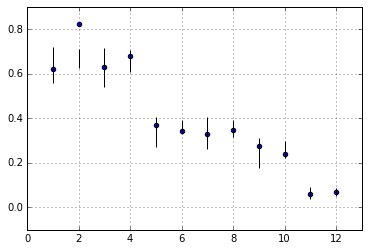

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

real_acceptance = data['admit'] / data['applications']

ax.scatter(real_acceptance.index, real_acceptance.values)
ax.vlines(post.index, post.iloc[:,0], post.iloc[:,2])


ax.set_xlim([0, 13]);
ax.grid();

### 10.2 Poisson regression

In [38]:
d = pd.read_csv('./rethinking/data/Kline.csv', sep=';')

d['log_pop'] = np.log(d['population'])
d[['contact_high', 'contact_low']] = pd.get_dummies(d['contact'])


In [40]:
with pm.Model() as m1010:
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta_p = pm.Normal('beta_p', mu=0, sd=1)
    beta_c = pm.Normal('beta_c', mu=0, sd=1)
    beta_pc = pm.Normal('beta_pc', mu=0, sd=1)
    
    lambda_ = np.exp(alpha
                     + beta_p * d['log_pop']
                     + beta_c * d['contact_high']
                     + beta_pc * d['log_pop'] * d['contact_high'])
                     
    tools = pm.Poisson('tools', mu=lambda_, observed=d['total_tools'])
    
    m1010_map = pm.find_MAP()
    m1010_traces = pm.sample(1000, start=m1010_map)

100%|██████████| 1000/1000 [00:03<00:00, 299.12it/s]


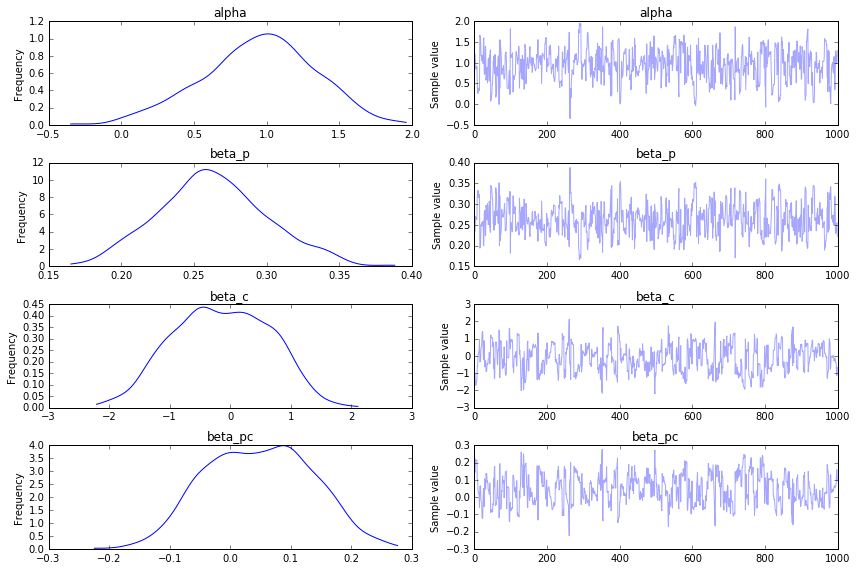

In [41]:
pm.traceplot(m1010_traces);

In [42]:
pm.summary(m1010_traces)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.947            0.386            0.019            [0.196, 1.686]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.155          0.709          0.969          1.200          1.650


beta_p:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.263            0.037            0.002            [0.196, 0.341]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.194          0.238          0.262          0.286          0.340


beta_c:

  Mean             SD               MC Error         95% HPD interval
  -----------------------

In [43]:
m1010_traces_df = pm.trace_to_dataframe(m1010_traces)

In [44]:
def traces_to_dotplot(traces_df):
    fig, ax = plt.subplots(1,1, figsize=(6, 1.5))

    param_qs = traces_df.quantile([0.055, 0.5, 0.945])

    for index, col in enumerate(param_qs.columns):
        col_qs = param_qs[col]
        ax.scatter(col_qs.median(), index)
        ax.hlines(index, col_qs.min(), col_qs.max())

    ax.set_yticks(range(len(param_qs.columns)))
    ax.set_yticklabels(param_qs.columns)
    ax.grid();
    
    return (fig, ax)

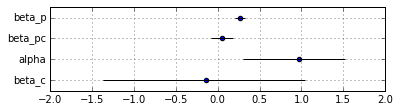

In [45]:
traces_to_dotplot(m1010_traces_df);

In [46]:
cfact_log_pop = 8 

lambda_high = m1010_traces_df.apply(
    lambda row: row['alpha'] + row['beta_p'] * cfact_log_pop + row['beta_c'] + row['beta_pc'] * cfact_log_pop, axis=1)

lambda_low = m1010_traces_df.apply(
    lambda row: row['alpha'] + row['beta_p'] * cfact_log_pop, axis=1)

lambda_high = np.exp(lambda_high)
lambda_low = np.exp(lambda_low)

lambda_diff = lambda_high - lambda_low
(lambda_diff > 0).value_counts(normalize=True)

True     0.956
False    0.044
dtype: float64

There is a 96% plausibility that a high contact island has more tools than a low contact island.

You can't just inspect the marginal uncertainty in each parameter, which is what is shown in the table of estimates,
and get an accurate understanding of the impact of the joint uncertainty on prediction -- the correlation between beta_c and beta_pc is strongly negative, so when beta_c is small, beta_pc is large = inspecting just one parameter (beta_c) doesn't explain the joint impact of parameters on prediction.

A better way to assess whether a predictor is expected to improve prediction is to use **model comparisons**.